In [ ]:
import sys
!{sys.executable} -m pip install pandas matplotlib seaborn

In [69]:
import requests
import pandas as pd

# Step 1: Request only necessary fields
fields = "cca2,cca3,cioc,name,capital,region,subregion,languages,area,population"

url = f"https://restcountries.com/v3.1/all?fields={fields}"
response = requests.get(url)
countries = response.json()

# Step 2: Process and clean data
data = []
for country in countries:
    row = {
        "cca2": country.get("cca2", ""),
        "cca3": country.get("cca3", ""),
        "cioc": country.get("cioc", ""),
        "name_common": country.get("name", {}).get("common", ""),
        "name_official": country.get("name", {}).get("official", ""),
        "capital": ', '.join(country.get("capital", [])),
        "region": country.get("region", ""),
        "subregion": country.get("subregion", ""),
        "languages": '\n'.join(country.get("languages", {}).values()) if country.get("languages") else "",
        "area": country.get("area", 0),
        "population": country.get("population", 0)
    }
    data.append(row)

# Step 3: Save to CSV using pandas
df = pd.DataFrame(data)
df.to_csv("countries_filtered.csv", index=False)

print("Saved to countries_filtered.csv")


Saved to countries_filtered.csv


# Task 3. В дополнение к предыдущему заданию сделайте следующее:
 - вместо записи в CSV файл сделайте так, чтобы данные записывались в базу данных. 
При повторном запуске кода новые или измененные данные из источника должны вставляться/обновляться в базе данных.
 - напишите (и сохраните для дальнейшей демонстрации) SQL запросы в базе данных, которые выводят следующую информацию
	- сумму популяций всех стран, в которых говорят на английском языке
	- все саб-регионы и количество стран в каждом из них (без дублирований стран по языкам)
	- все страны (и их языки), в которых говорят больше, чем на одном языке
	- топ-3 регионов с наибольшим количеством используемых языков.
	- название столицы той страны, в которой: 
		1)говорят больше, чем на 3 языках
		2)население менее 14 млн
		3)вторая по наименьшей площади страна, удовлетворяющая предыдущим требованиям


In [70]:
import sqlite3

fields = "cca2,cca3,cioc,name,capital,region,subregion,languages,area,population"
url = f"https://restcountries.com/v3.1/all?fields={fields}"
response = requests.get(url)
countries = response.json()

data = []
for country in countries:
    row = {
        "cca2": country.get("cca2", ""),
        "cca3": country.get("cca3", ""),
        "cioc": country.get("cioc", ""),
        "name_common": country.get("name", {}).get("common", ""),
        "name_official": country.get("name", {}).get("official", ""),
        "capital": ', '.join(country.get("capital", [])),
        "region": country.get("region", ""),
        "subregion": country.get("subregion", ""),
        "languages": ', '.join(country.get("languages", {}).values()) if country.get("languages") else "",
        "language_count": len(country.get("languages", {})) if country.get("languages") else 0,
        "area": country.get("area", 0),
        "population": country.get("population", 0)
    }
    data.append(row)

df = pd.DataFrame(data)

conn = sqlite3.connect("countries.db")
cursor = conn.cursor()

cursor.execute('''
CREATE TABLE IF NOT EXISTS countries (
    cca2 TEXT PRIMARY KEY,
    cca3 TEXT,
    cioc TEXT,
    name_common TEXT,
    name_official TEXT,
    capital TEXT,
    region TEXT,
    subregion TEXT,
    languages TEXT,
    language_count INTEGER,
    area REAL,
    population INTEGER
)
''')


for _, row in df.iterrows():
    cursor.execute('''
    INSERT INTO countries (cca2, cca3, cioc, name_common, name_official, capital, region, subregion,
                           languages, language_count, area, population)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ON CONFLICT(cca2) DO UPDATE SET
        cca3=excluded.cca3,
        cioc=excluded.cioc,
        name_common=excluded.name_common,
        name_official=excluded.name_official,
        capital=excluded.capital,
        region=excluded.region,
        subregion=excluded.subregion,
        languages=excluded.languages,
        language_count=excluded.language_count,
        area=excluded.area,
        population=excluded.population
    ''', tuple(row))

conn.commit()
conn.close()

### SQL QUERIES 
(I've used "with
" statement for each subtask so thats repeated in order to show the result for each cell)

	- сумму популяций всех стран, в которых говорят на английском языке
	- все саб-регионы и количество стран в каждом из них (без дублирований стран по языкам)
	- все страны (и их языки), в которых говорят больше, чем на одном языке
	- топ-3 регионов с наибольшим количеством используемых языков.
	- название столицы той страны, в которой: 
		1)говорят больше, чем на 3 языках
		2)население менее 14 млн
		3)вторая по наименьшей площади страна, удовлетворяющая предыдущим требованиям



In [71]:
with sqlite3.connect("countries.db") as conn:

    # 1️⃣ Общая численность населения стран, где говорят на английском языке
    query1 = """
    SELECT 
        SUM(population) AS total_population_english
    FROM countries
    WHERE languages LIKE '%English%'
    """
    df1 = pd.read_sql_query(query1, conn)
    total_pop = df1.iloc[0, 0]
    print("1️⃣ Общая численность населения стран, где говорят на английском языке:")
    print(f"→ {total_pop:,} человек\n")  # formatted with thousands separator

1️⃣ Общая численность населения стран, где говорят на английском языке:
→ 2,882,794,269 человек



In [72]:
with sqlite3.connect("countries.db") as conn:
    # 2️⃣ Все субрегионы и количество стран в каждом
    query2 = """
    SELECT 
        subregion AS 'Субрегион', 
        COUNT(*) AS 'Количество стран'
    FROM countries
    GROUP BY subregion
    ORDER BY COUNT(*) DESC
    """
    df2 = pd.read_sql_query(query2, conn)
    print("2️⃣ Количество стран по субрегионам:")
    # print(df2.to_string(index=False), "\n")
df2 

2️⃣ Количество стран по субрегионам:


,Субрегион,Количество стран
0,Caribbean,28
1,Eastern Africa,19
2,Western Asia,17
3,Western Africa,17
4,Northern Europe,16
5,South America,14
6,South-Eastern Asia,11
7,Southern Europe,10
8,Polynesia,10
9,Middle Africa,10


In [73]:
with sqlite3.connect("countries.db") as conn:
    # 3️⃣ Все страны с более чем одним языком
    query3 = """
    SELECT 
        name_common AS 'Страна', 
        languages AS 'Языки'
    FROM countries
    WHERE language_count > 1
    ORDER BY name_common
    """
    df3 = pd.read_sql_query(query3, conn)
    print("3️⃣ Страны, где говорят более чем на одном языке:")
    # print(df3.to_string(index=False), "\n")
df3

3️⃣ Страны, где говорят более чем на одном языке:


,Страна,Языки
0,Afghanistan,"Dari, Pashto, Turkmen"
1,American Samoa,"English, Samoan"
2,Argentina,"Guaraní, Spanish"
3,Aruba,"Dutch, Papiamento"
4,Belarus,"Belarusian, Russian"
...,...,...
92,Uzbekistan,"Russian, Uzbek"
93,Vanuatu,"Bislama, English, French"
94,Vatican City,"Italian, Latin"
95,Western Sahara,"Berber, Hassaniya, Spanish"


In [74]:
with sqlite3.connect("countries.db") as conn:
    # 4️⃣ Топ-3 регионов по общему количеству используемых языков
    query4 = """
    SELECT 
        region AS 'Регион', 
        SUM(language_count) AS 'Всего языков'
    FROM countries
    GROUP BY region
    ORDER BY SUM(language_count) DESC
    LIMIT 3
    """
    df4 = pd.read_sql_query(query4, conn)
    print("4️⃣ Топ-3 регионов по количеству используемых языков:")
    # print(df4.to_string(index=False), "\n")

df4

4️⃣ Топ-3 регионов по количеству используемых языков:


,Регион,Всего языков
0,Africa,128
1,Europe,82
2,Americas,76


In [75]:

with sqlite3.connect("countries.db") as conn:
    # 5️⃣ Столица второй наименьшей по площади страны, где:
    #    - более 3 языков
    #    - население менее 14 млн
    
    query5 = """
    SELECT 
        capital AS 'Столица', 
        name_common AS 'Страна', 
        area AS 'Площадь',
        population AS 'Население',
        language_count AS 'Кол-во языков'
    FROM countries
    WHERE 
        language_count > 3 AND population < 14000000
    ORDER BY area ASC
    LIMIT 1 
    OFFSET 1
    """
    
    df5 = pd.read_sql_query(query5, conn)
    print("5️⃣ Страна, соответствующая условиям (вторая по наименьшей площади):")
    # print(df5.to_string(index=False), "\n")
df5

5️⃣ Страна, соответствующая условиям (вторая по наименьшей площади):


,Столица,Страна,Площадь,Население,Кол-во языков
0,Bern,Switzerland,41284.0,8654622,4


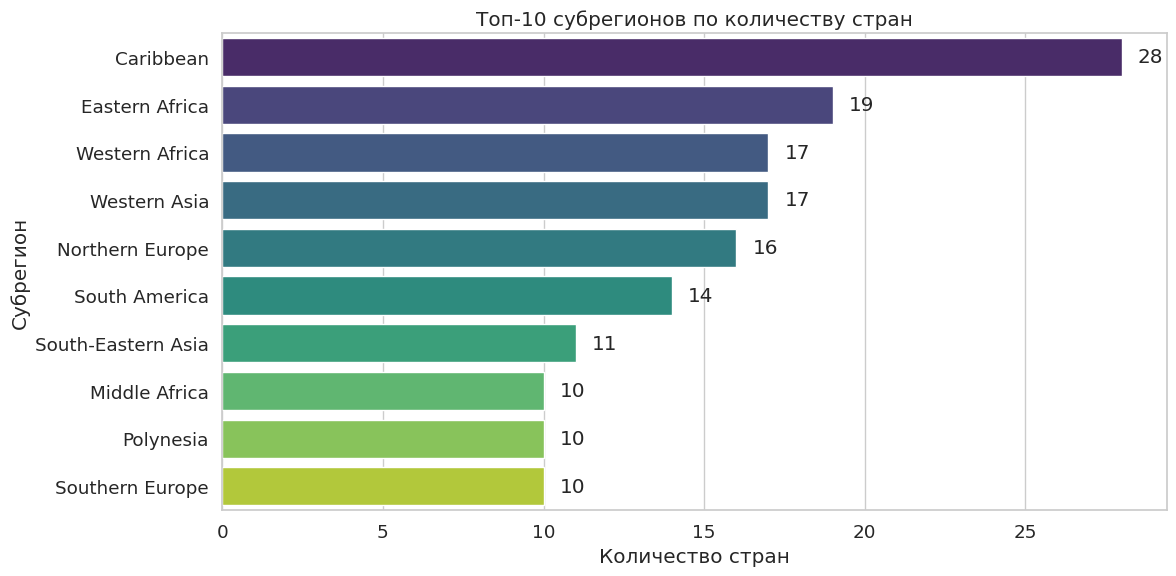

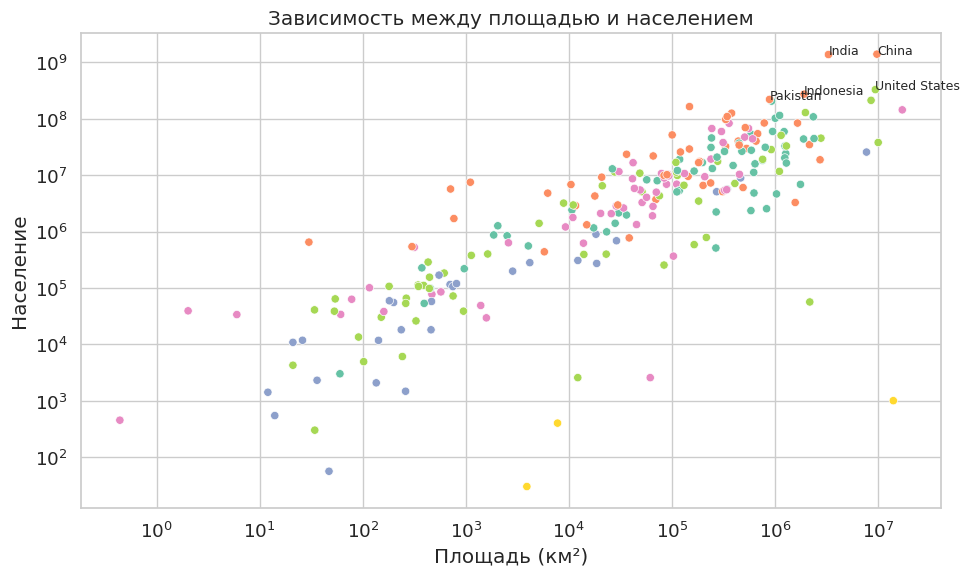

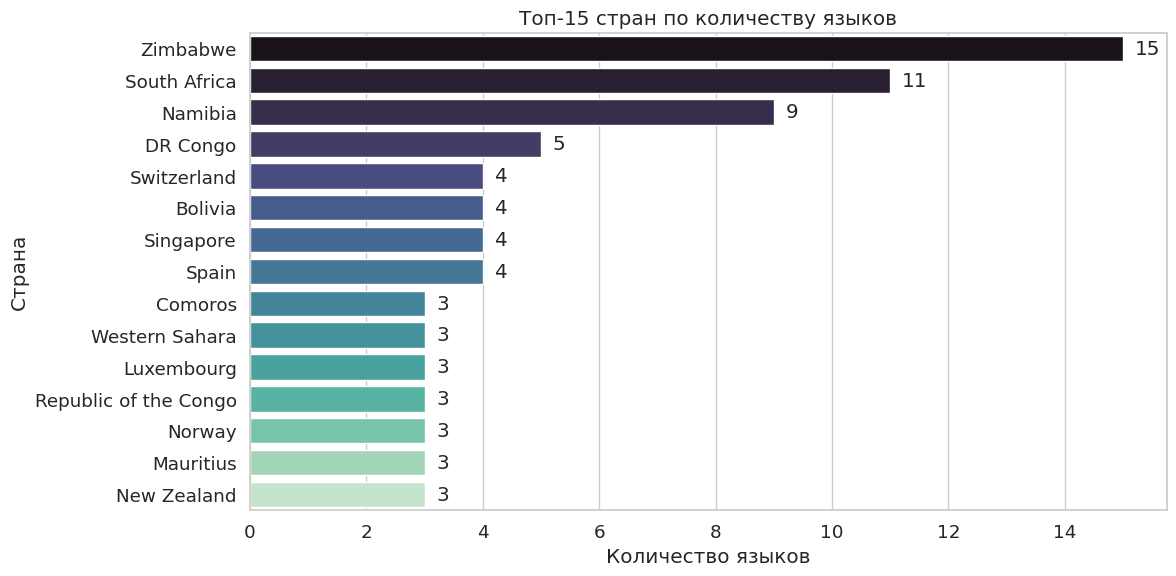

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", font="DejaVu Sans", font_scale=1.2)

with sqlite3.connect("countries.db") as conn:
    df = pd.read_sql_query("SELECT * FROM countries", conn)

# -------------------------------
# 1️⃣ Топ-10 субрегионов по количеству стран
top_subregions = df['subregion'].value_counts().nlargest(10).reset_index()
top_subregions.columns = ['Субрегион', 'Количество стран']

plt.figure(figsize=(12, 6))
ax1 = sns.barplot(data=top_subregions, x='Количество стран', y='Субрегион', hue='Субрегион', palette='viridis')
plt.title("Топ-10 субрегионов по количеству стран")
plt.xlabel("Количество стран")
plt.ylabel("Субрегион")

# 🔢 Add labels
for i, (value, name) in enumerate(zip(top_subregions['Количество стран'], top_subregions['Субрегион'])):
    ax1.text(value + 0.5, i, str(value), va='center')

plt.tight_layout()
plt.show()

# -------------------------------
# 2️⃣ Зависимость между площадью и населением
plt.figure(figsize=(10, 6))
ax2 = sns.scatterplot(data=df, x='area', y='population', hue='region', palette='Set2', legend=False)
plt.xscale("log")
plt.yscale("log")
plt.title("Зависимость между площадью и населением")
plt.xlabel("Площадь (км²)")
plt.ylabel("Население")

# 🔢 Optional: label some key outliers (like top 5 most populous countries)
top_pop = df.sort_values(by='population', ascending=False).head(5)
for _, row in top_pop.iterrows():
    ax2.text(row['area'], row['population'], row['name_common'], fontsize=9)

plt.tight_layout()
plt.show()

# -------------------------------
# 3️⃣ Топ-15 стран по количеству языков
top_languages = df[['name_common', 'language_count']].sort_values(by='language_count', ascending=False).head(15)

plt.figure(figsize=(12, 6))
ax3 = sns.barplot(data=top_languages, x='language_count', y='name_common', palette='mako',hue='name_common')
plt.title("Топ-15 стран по количеству языков")
plt.xlabel("Количество языков")
plt.ylabel("Страна")

# 🔢 Add labels
for i, (count, name) in enumerate(zip(top_languages['language_count'], top_languages['name_common'])):
    ax3.text(count + 0.2, i, str(count), va='center')

plt.tight_layout()
plt.show()


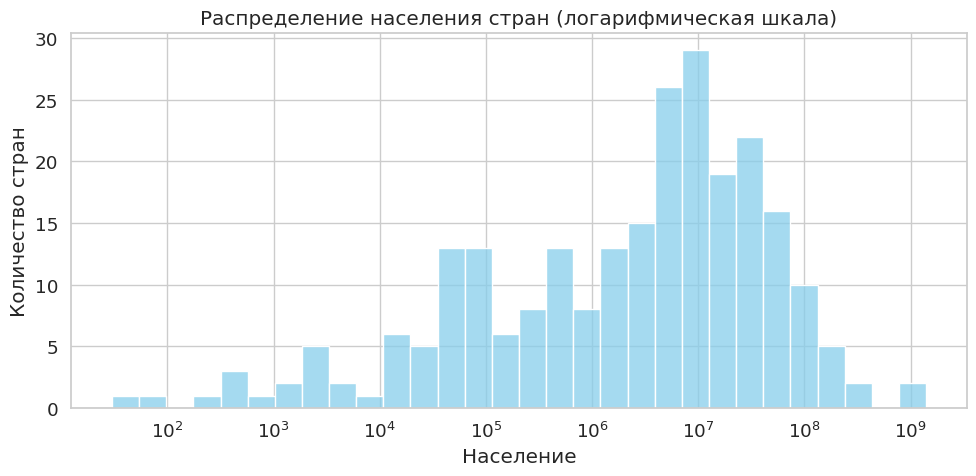

In [94]:
plt.figure(figsize=(10, 5))
sns.histplot(df['population'], bins=30, log_scale=True, color='skyblue')
plt.title("Распределение населения стран (логарифмическая шкала)")
plt.xlabel("Население")
plt.ylabel("Количество стран")
plt.tight_layout()
plt.show()

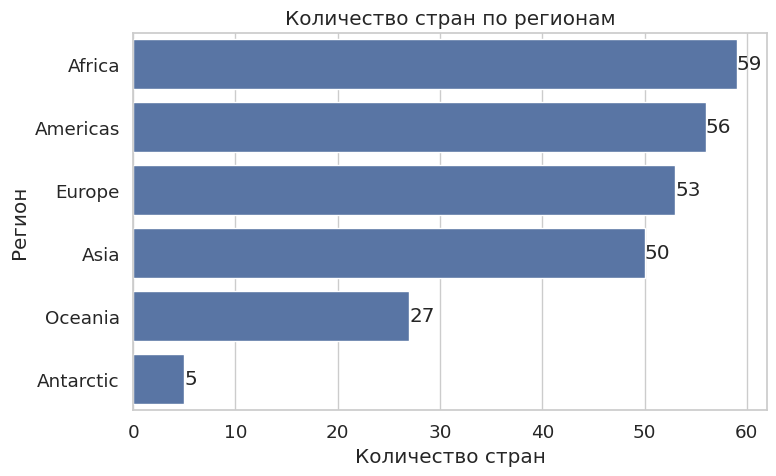

In [97]:
region_counts = df['region'].value_counts().reset_index()
region_counts.columns = ['Регион', 'Количество стран']

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=region_counts, x='Количество стран', y='Регион')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')
plt.title("Количество стран по регионам")
plt.tight_layout()
plt.show()


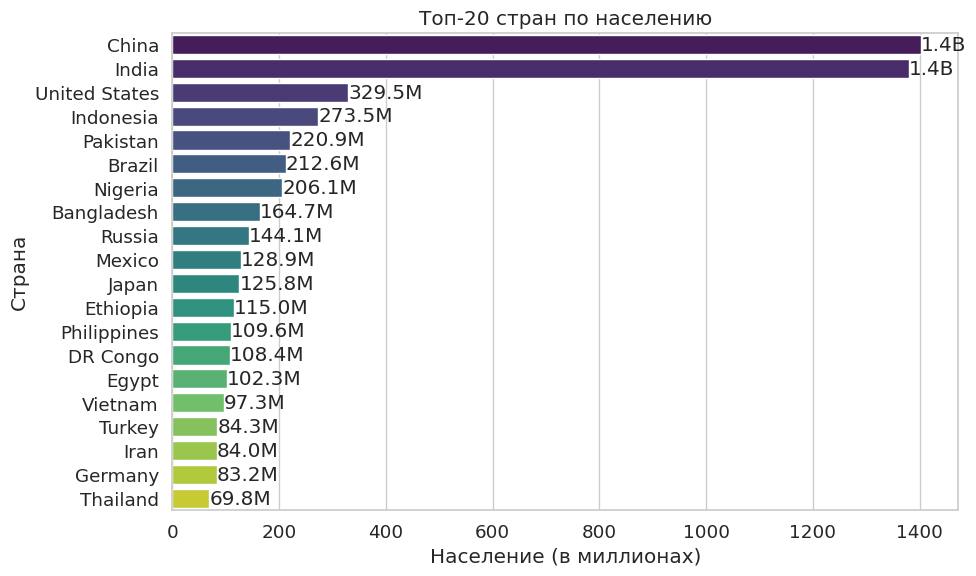

In [100]:
top_pop = df.sort_values(by='population', ascending=False).head(20)

# Convert population to millions
top_pop['population_m'] = top_pop['population'] / 1_000_000

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top_pop, x='population_m', y='name_common', palette='viridis', hue='name_common')

# Format labels smartly: M or B
def format_pop(val):
    if val >= 1000:
        return f"{val/1000:.1f}B"
    else:
        return f"{val:.1f}M"

for container in ax.containers:
    labels = [format_pop(val) for val in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='edge')

plt.title("Топ-20 стран по населению")
plt.xlabel("Население (в миллионах)")
plt.ylabel("Страна")
plt.tight_layout()
plt.show()

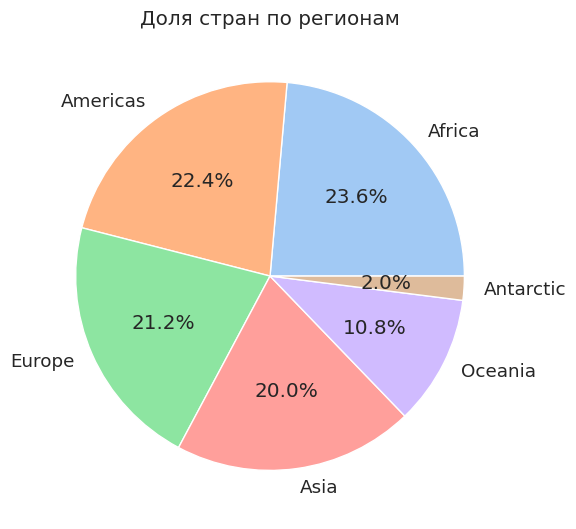

In [83]:
continent_counts = df['region'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(continent_counts, labels=continent_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title("Доля стран по регионам")
plt.tight_layout()
plt.show()


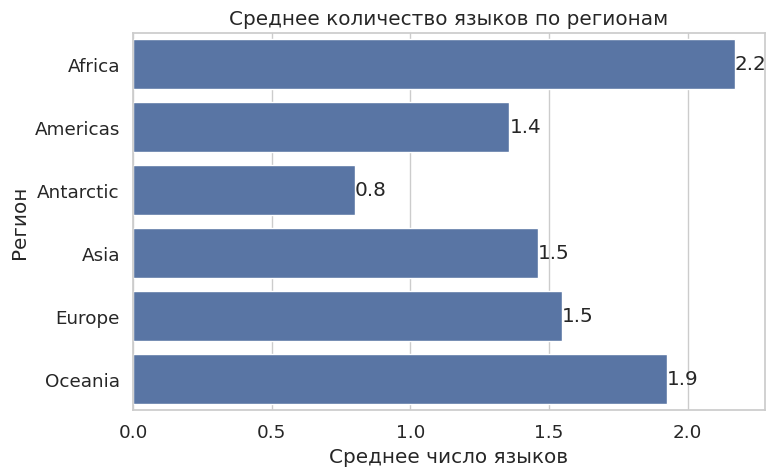

In [93]:
avg_lang_region = df.groupby('region')['language_count'].mean().reset_index()

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=avg_lang_region, x='language_count', y='region')
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', label_type='edge')
plt.title("Среднее количество языков по регионам")
plt.xlabel("Среднее число языков")
plt.ylabel("Регион")
plt.tight_layout()
plt.show()


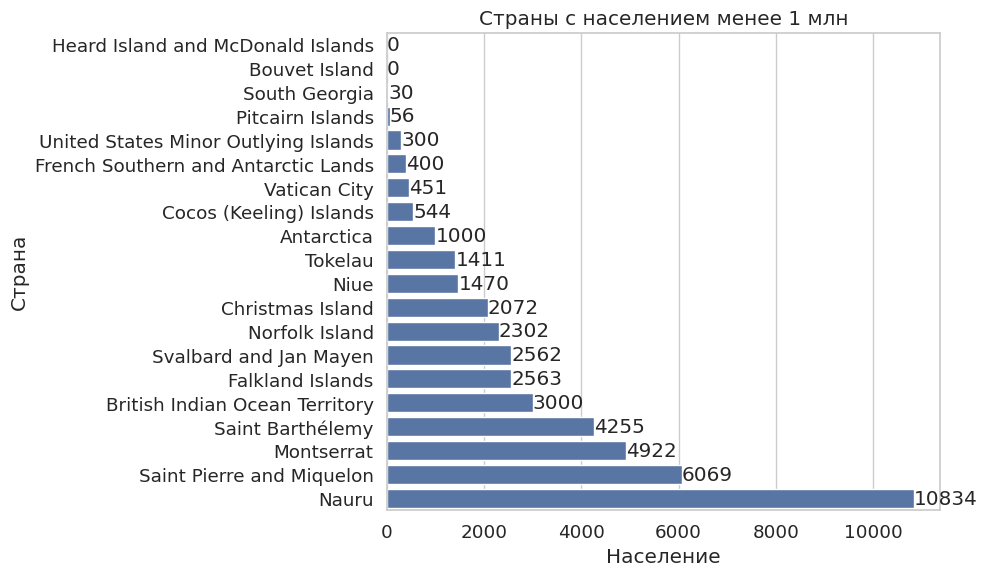

In [101]:
small_pop = df[df['population'] < 1_000_000].sort_values(by='population')

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=small_pop.head(20), x='population', y='name_common')
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge')
plt.title("Страны с населением менее 1 млн")
plt.xlabel("Население")
plt.ylabel("Страна")
plt.tight_layout()
plt.show()


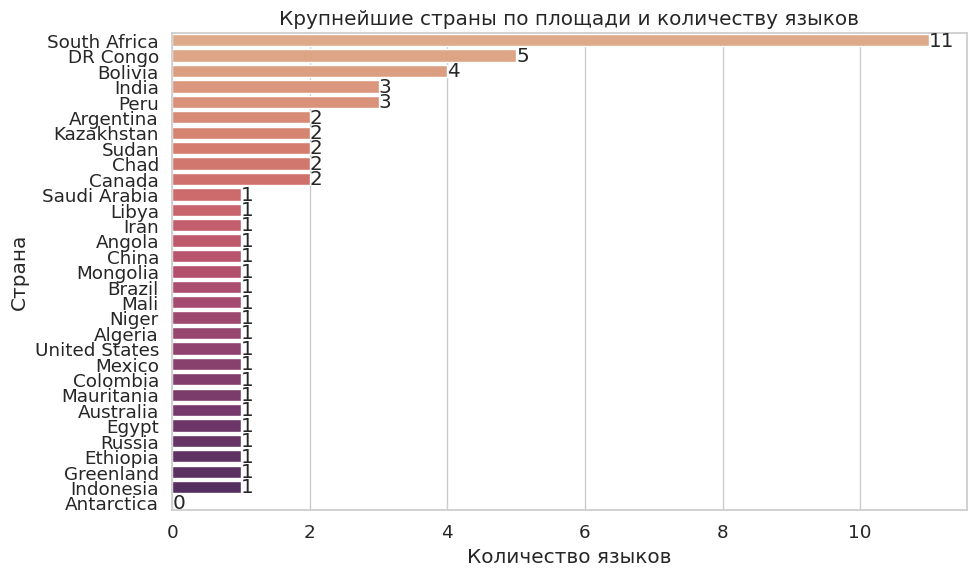

In [103]:
large_area = df[df['area'] > 1_000_000]
sorted_large = large_area.sort_values(by='language_count', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=sorted_large, x='language_count', y='name_common',
                 palette='flare', hue='name_common', dodge=False)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')
plt.title("Крупнейшие страны по площади и количеству языков")
plt.xlabel("Количество языков")
plt.ylabel("Страна")
plt.tight_layout()
plt.show()


# 5. Описание выполненных задач (Задания 2, 3 и 4)

## Задание 2 — Парсинг данных из REST Countries API

В этом задании был реализован Python-скрипт, который:

- Обращается к API: `https://restcountries.com/v3.1/all`
- Извлекает следующие поля из JSON:
  - `cca2`, `cca3`, `cioc`
  - `name.common`, `name.official`
  - `capital`, `region`, `subregion`
  - `languages` (каждый язык сохраняется на отдельной строке)
  - `area`, `population`
- Результаты сохраняются в формате CSV (`countries.csv`)


##  Задание 3 — Сохранение в базу данных и SQL-запросы

- Вместо сохранения в CSV, данные были сохранены в базу данных SQLite (`countries.db`)
- При повторном запуске:
  - Скрипт вставляет только новые страны
  - Обновляет изменённые данные
- Были написаны и выполнены следующие SQL-запросы:

1. **Сумма популяций стран, где говорят на английском:**
   ```sql
   SELECT SUM(population)
   FROM countries
   JOIN country_languages USING(cca3)
   WHERE language = 'English';
   ```

2. **Все сабрегионы и количество стран в каждом:**
   ```sql
   SELECT subregion, COUNT(DISTINCT cca3) AS country_count
   FROM countries
   GROUP BY subregion;
   ```

3. **Страны, где говорят более чем на одном языке:**
   ```sql
   SELECT countries.name_common, COUNT(language) as lang_count
   FROM countries
   JOIN country_languages USING(cca3)
   GROUP BY countries.cca3
   HAVING lang_count > 1;
   ```

4. **Топ-3 регионов по количеству используемых языков:**
   ```sql
   SELECT region, COUNT(DISTINCT language) as lang_total
   FROM countries
   JOIN country_languages USING(cca3)
   GROUP BY region
   ORDER BY lang_total DESC
   LIMIT 3;
   ```

5. **Столица второй по наименьшей площади страны, где:**
   - более 3 языков
   - население < 14 млн
   ```sql
   SELECT capital
   FROM (
     SELECT countries.capital, area
     FROM countries
     JOIN country_languages USING(cca3)
     GROUP BY cca3
     HAVING COUNT(language) > 3 AND population < 14000000
     ORDER BY area ASC
     LIMIT 2
   ) LIMIT 1 OFFSET 1;
   ```

## Задание 4 — Визуализация данных

https://uyivzola-country-streamlit-mini-project-run-po2hnr.streamlit.app/
- Использована библиотека **Streamlit** для построения интерактивного веб-приложения
- Реализовано две главные секции:
  1. **Дашборд (dashboard section)**:
     - Графики по регионам, языкам, плотности населения, населению и т.д.
     - Используются библиотеки `plotly`, `pandas`, `sqlite3`
  2. **Подробности о стране (details section)**:
     - Информация о выбранной стране, включая:
       - Флаг, герб, население, площадь, валюту, языки, соседей
       - Интерактивная карта с помощью `folium`
       - Полный JSON-ответ

- Финальное объединение — одностраничное Streamlit-приложение с двумя секциями:
  - Дашборд с визуализациями
  - Страница с детальной информацией по стране
      
